In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm.auto import tqdm
import datetime
import random

import torch
from torch import nn
from torchvision import models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

## Two main types

> The Backbone (or "Convolutional Base") <br>
The Head (or "Classifier")


1. Feature Extraction

We "freeze" the weights (parameters) of the backbone layers. Then we chop off the original classifier head and replace it with a new, untrained head designed for our task
- Your new dataset is small and somewhat similar to the original training data (e.g., ImageNet).
- You want a quick and computationally cheap training process.
- It's a great first step and strong baseline for any new project.

<br>

2. Fine-Tuning (Partially Train Higher Layers)

**Unfreeze Some Layers:** We typically keep the early layers frozen (because they detect universal features like edges) and unfreeze the later layers.

> Why Later Layers? The later layers in the backbone have learned the most complex, task-specific features (e.g., "dog snout" or "car wheel"). We want to give the model a chance to "forget" some of these very specific ImageNet features and adjust them to our data (e.g., learn the specific shape of a "Persian cat's face").

- Your new dataset is relatively large (thousands of examples).
- Your new dataset is significantly different from the original training data (e.g., the pre-trained model was on natural images, but your task is medical X-rays).
- You need the highest possible accuracy and have the computational budget for it.

### 1. Feature Extraction

#### **Check available models**

`models.list_models()`

and their availabel weights:

`models.get_model_weights(model_name)`

In [231]:
models.list_models(
    module = models.segmentation,
    include = '*resnet*' # Unix wild card
)

['deeplabv3_resnet101', 'deeplabv3_resnet50', 'fcn_resnet101', 'fcn_resnet50']

In [51]:
for weight in models.get_model_weights('deeplabv3_resnet101'):
    print(weight)

DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1


In [4]:
# Load the model
model = models.resnet18(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [10]:
# # There are two ways to check the model layers
# for name, parameter in model.named_parameters():
#     print(name)

# # Or just print the model
# print(model)

In [17]:
# Replace the head
in_feat = model.fc.in_features
model.fc = nn.Linear(in_feat, 1)

In [18]:
# Now it's time to freeze the model weights
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

### 2. Fine-Tuning (Partially Train Higher Layers)

In [19]:
# Now it's time to freeze the model weights
for name, param in model.named_parameters():
    if 'fc' in name or 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [22]:
# Check unfreezed layers
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


### Prepare image

orchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the `weight.transforms` attribute:

In [25]:
weight = models.ResNet18_Weights.DEFAULT
transform = weight.transforms()

transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Quantization

Converts a model's weights and activations from high-precision floating-point numbers (like FP32 - 32 bits) to lower-precision integers (like INT8 - 8 bits).
  
- Smaller Model Size (~4x reduction: 32-bit → 8-bit)
- Faster Inference (integer operations are faster than floating-point)
- Lower Memory Bandwidth
- Better Power Efficiency

after fine-tuning the model we can do this:

```py
quantized_model = torch.quantization.quantize_dynamic(
    model,
    {nn.Linear, nn.Conv2d},  # Layers to quantize
    dtype=torch.qint8
)
```

## Fine tune cats and dogs

In [2]:
#!/bin/bash
!curl -L -o ./catsvsdogs.zip https://www.kaggle.com/api/v1/datasets/download/shaunthesheep/microsoft-catsvsdogs-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  787M  100  787M    0     0   113M      0  0:00:06  0:00:06 --:--:--  168M


In [ ]:
!unzip catsvsdogs.zip

In [16]:
path = '/content/PetImages'

labels_dict = {}
items = []
for i, dir in enumerate(os.listdir(path)):
    labels_dict[i] = dir
    for file in tqdm(os.listdir(os.path.join(path, dir))):
        if '.jpg' in file:
            items.append((os.path.join(path, dir, file), i))


  0%|          | 0/12501 [00:00<?, ?it/s]

  0%|          | 0/12501 [00:00<?, ?it/s]

In [17]:
random.shuffle(items)

In [18]:
labels_dict

{0: 'Cat', 1: 'Dog'}

In [19]:
model = models.resnet18(weights = 'DEFAULT')
in_feat = model.fc.in_features
model.fc = nn.Linear(in_feat, 1)

for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
class datasetCatDog(Dataset):
    def __init__(self, items, transform = None):
        super().__init__()
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        max_attempts = 10
        for attempt in range(max_attempts):
            try:
                current_idx = (idx + attempt) % len(self.items)
                img_path, label = self.items[current_idx]

                img = Image.open(img_path).convert('RGB')

                if self.transform:
                    img = self.transform(img)

                return img, label

            except Exception as e:
                # Skip this image and try the next one
                print(f"Skipping corrupted image ({attempt + 1}/{max_attempts}): {img_path}")
                continue

In [47]:
weight = models.ResNet18_Weights.DEFAULT
transform = weight.transforms()

transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [48]:
split = int(len(items) * 0.8)
train_dataset = datasetCatDog(items[:split], transform)
test_dataset = datasetCatDog(items[split:], transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

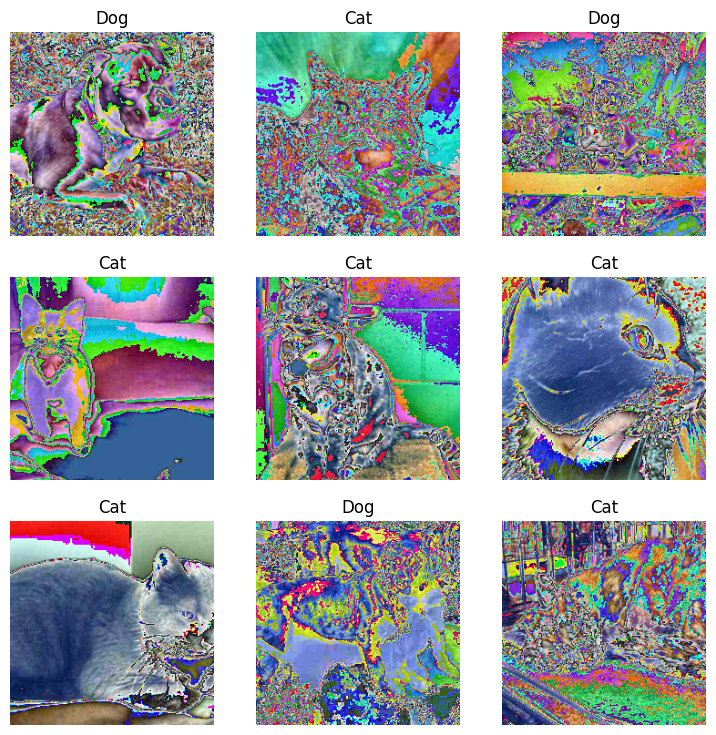

In [49]:
plt.figure(figsize = (9, 9))

rows, cols = 3, 3
for i in range(rows * cols):
    idx = random.randint(0, len(train_dataset))
    img, label = train_dataset[idx]
    plt.subplot(rows, cols, i + 1)
    img = T.ToPILImage()(img)
    plt.imshow(img)
    plt.axis(False)
    plt.title(labels_dict[label])

plt.show()

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calc_metrics(y_true, pred):
    return{
        'accuracy': accuracy_score(y_true, pred),
        'precision': precision_score(y_true, pred),
        'recall': recall_score(y_true, pred),
        'f1': f1_score(y_true, pred)
    }

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)
lr_schduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.9)
loss_fn = nn.BCEWithLogitsLoss()


In [65]:
epochs = 2

train_losses = []
train_metrics = {}

outer_pbar = tqdm(range(epochs), desc = 'Epochs')
for epoch in outer_pbar:
    model.train()
    train_loss = 0
    train_met = {}
    step = 0
    inner_pbar = tqdm(train_loader, desc = 'Train', leave = False)
    for X, y in inner_pbar:
        step += 1
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()

        train_loss += loss.item()
        metrics = calc_metrics(y.cpu().detach().numpy(), torch.round(torch.sigmoid(y_pred)).cpu().detach().numpy())

        for key, value in metrics.items():
            if key not in train_met:
                train_met[key] = []
            train_met[key].append(value)

        if step % 10 == 0:
            inner_pbar.set_postfix({
                'loss': loss.item(),
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1']
            })

    train_losses.append(train_loss / len(train_loader))
    for key, value in train_met.items():
        train_metrics[key] = np.mean(value)

    lr_schduler.step()
    outer_pbar.set_postfix({
        'loss': train_loss / len(train_loader),
        'accuracy': train_metrics['accuracy'],
        'precision': train_metrics['precision'],
        'recall': train_metrics['recall'],
        'f1': train_metrics['f1']

    })

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Skipping corrupted image (1/10): /content/PetImages/Dog/11702.jpg
Skipping corrupted image (1/10): /content/PetImages/Cat/666.jpg


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train:   0%|          | 0/625 [00:00<?, ?it/s]

Skipping corrupted image (1/10): /content/PetImages/Dog/11702.jpg


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping corrupted image (1/10): /content/PetImages/Cat/666.jpg


In [74]:
from torchvision.utils import make_grid

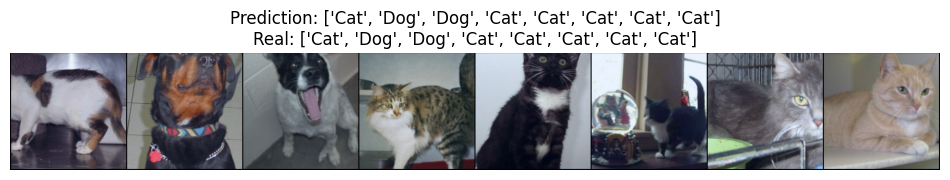

In [116]:
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        break

pred = (torch.sigmoid(pred).squeeze().detach().cpu().numpy() > 0.5).astype(int)
grid = make_grid(X[:8], normalize= True)

plt.figure(figsize = (12, 12))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title(f'Prediction: {[labels_dict[pred[i]] for i in pred[:8]]}\n'
          f'Real: {[labels_dict[y.cpu().numpy()[i]] for i in pred[:8]]}')
plt.axis(False)
plt.show()

In [113]:
# Download an image from internet
!wget https://img.freepik.com/free-photo/portrait-beautiful-purebred-pussycat-with-shorthair-orange-collar-neck-sitting-floor-reacting-camera-flash-scared-looking-light-indoor_8353-12551.jpg?semt=ais_hybrid&w=740&q=80

--2025-10-20 09:44:06--  https://img.freepik.com/free-photo/portrait-beautiful-purebred-pussycat-with-shorthair-orange-collar-neck-sitting-floor-reacting-camera-flash-scared-looking-light-indoor_8353-12551.jpg?semt=ais_hybrid
Resolving img.freepik.com (img.freepik.com)... 184.30.148.200, 184.30.148.208, 2600:1406:4e00:1a::1738:6d24, ...
Connecting to img.freepik.com (img.freepik.com)|184.30.148.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48322 (47K) [image/jpeg]
Saving to: ‘portrait-beautiful-purebred-pussycat-with-shorthair-orange-collar-neck-sitting-floor-reacting-camera-flash-scared-looking-light-indoor_8353-12551.jpg?semt=ais_hybrid.2’

portrait-beautiful- 100%[===================>]  47.19K  --.-KB/s    in 0.001s  

2025-10-20 09:44:06 (52.8 MB/s) - ‘portrait-beautiful-purebred-pussycat-with-shorthair-orange-collar-neck-sitting-floor-reacting-camera-flash-scared-looking-light-indoor_8353-12551.jpg?semt=ais_hybrid.2’ saved [48322/48322]



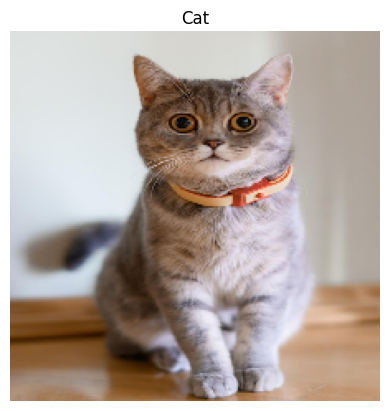

In [114]:
# img = Image.open('/content/ginger-maine-coon-kitten-running-on-lawn-in-royalty-free-image-1719608142.jpg?crop=1xw:0.84415xh')
img = Image.open('/content/portrait-beautiful-purebred-pussycat-with-shorthair-orange-collar-neck-sitting-floor-reacting-camera-flash-scared-looking-light-indoor_8353-12551.jpg?semt=ais_hybrid')
img_tensor = transform(img)

model.eval()
with torch.no_grad():
    pred = model(img_tensor.unsqueeze(0).to(device))
    pred = torch.round(torch.sigmoid(pred))

plt.imshow(img.resize((224, 224), Image.Resampling.NEAREST))
plt.title(labels_dict[pred.item()])
plt.axis(False)
plt.show()


## Lora

### **Rank:**
tells you the minimum number of vectors needed to span a space. In neural networks, the input and output layers have fixed dimensions, however, you can use low-rank operations to reduce the number of parameters. For instance we have two layers with 10 and 8 nodes, so we have $10\ast8\ =\ 80$ computation. Now, if we add a layer with 3 nodes between them we will have $10 \ast 3 + 3  \ast 8 = 54$ computations.

The original neural network layer has a weight matrix $\mathbf{w}_\mathbf{0}^{\mathbf{d}\times\mathbf{k}}$  with dimensions d by k, where d is the input size, and k is the output size. The layers output gets computed as a function of $\mathbf{h} \left(\mathbf{x}\right)=\mathbf{W}_{0} \mathbf{x}$, $\mathcal{x}$ is the input from the last layer. Hence, the result in learnable parameter is $d\ \times k$.

$$
\left[\begin{matrix}w_{00}&w_{01}&\ldots&w_{0k}\\w_{10}&w_{11}&\ldots&w_{1k}\\\ldots&\ldots&\ldots&\ldots\\w_{d0}&w_{d1}&\ldots&w_{dk}\\\end{matrix}\right]\ \left[\begin{matrix}x_0\\x_1\\\ldots\\x_k\\\end{matrix}\right]\ =\left[\begin{matrix}h_0\\h_1\\\ldots\\h_d\\\end{matrix}\right]\
$$

<br>

An additional matrix $\Delta W$ is added to the original weight matrix W_0. Therefore, the new weight matrix is W=W_0+\ \Delta W, and the layers output becomes a function $\mathbf{h}\left(\mathbf{x}\right)=\mathbf{W}_\mathbf{0}\cdot\mathbf{x}+\mathbf{\Delta W}\cdot\mathbf{x}$. Next, upon decomposing the LoRA update, the matrix $\Delta W$ decomposes into two low rank matrices, B and A, meaning $\Delta W = B \times A$. A and B are the additional layers that map from a simpler to a larger dimension. The dimensions of B are $d\ \times r$, and that of A is $r \times k$, where r is the rank. The value of rank r should be smaller than d and k.


$$
h\left(x\right)=\left(\ \left[\begin{matrix}w_{00}&w_{01}&\ldots&w_{0k}\\w_{10}&w_{11}&\ldots&w_{1k}\\\ldots&\ldots&\ldots&\ldots\\w_{d0}&w_{d1}&\ldots&w_{dk}\\\end{matrix}\right]+\left[\begin{matrix}B_{00}&\ldots&B_{0r}\\B_{10}&\ldots&B_{1r}\\\ldots&\ldots&\ldots\\B_{d0}&\ldots&B_{dr}\\\end{matrix}\right]\times\left[\begin{matrix}A_{00}&A_{01}&\ldots&A_{0k}\\\ldots&\ldots&\ldots&\ldots\\A_{r0}&w_{r1}&\ldots&A_{rk}\\\end{matrix}\right]\right)\ \left[\begin{matrix}x_0\\x_1\\\ldots\\x_k\\\end{matrix}\right]\ =\left[\begin{matrix}h_0\\h_1\\\ldots\\h_d\\\end{matrix}\right]\
$$


In [181]:
class LoraLinearLayer(nn.Module):
    def __init__(self, layer, rank, out_feat=None, alpha = 8):
        super().__init__()

        self.rank = rank
        self.alpha = alpha

        self.layer = layer
        # Freeze the original layer parameters
        for param in self.layer.parameters():
            param.requires_grad = False

        self.A = nn.Parameter(torch.randn(layer.in_features, rank) * 0.02)
        self.B = nn.Parameter(torch.zeros(rank, layer.out_features))

        self.final = nn.Linear(layer.out_features, out_feat, bias = False) if out_feat else nn.Identity()

    def forward(self, x):
        original = self.layer(x)
        lora = (x @ self.A @ self.B) * (self.alpha / self.rank)

        return self.final(original + lora)

In [203]:
import torch.nn.functional as F


class LoraConvLayer(nn.Module):
    def __init__(self, layer, rank, alpha = 8):
        super().__init__()

        self.rank = rank
        self.alpha = alpha

        self.layer = layer
        # Freeze the original layer parameters
        for param in self.layer.parameters():
            param.requires_grad = False

        # LoRA for Conv2d - different approach needed
        in_ch = layer.in_channels
        out_ch = layer.out_channels
        kernel_size = layer.kernel_size

        self.A = nn.Parameter(
            torch.randn(rank, in_ch, kernel_size[0], kernel_size[1]) * 0.02
        )
        self.B = nn.Parameter(
            torch.zeros(out_ch, rank, 1, 1)
        )

    def forward(self, x):
        original = self.layer(x)

        lora = F.conv2d(x, self.A, padding=self.layer.padding)  # First convolution
        lora = F.conv2d(lora, self.B)  # Second convolution
        lora = lora * (self.alpha / self.rank)

        return original + lora

In [222]:
model = models.resnet18(weights = 'DEFAULT')
for name, module in model.layer4.named_modules():
    if isinstance(module, nn.Conv2d):
        print(module)

Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [238]:
model.layer4[-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): LoraConvLayer(
    (layer): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [223]:
for params in model.parameters():
    params.requires_grad = False

print('trainabl params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

model.fc = LoraLinearLayer(model.fc, out_feat=1, rank = 10)
print('trainabl params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

# just change the latest conv
model.layer4[-1].conv2 = LoraConvLayer(model.layer4[-1].conv2, rank = 10)
print('trainabl params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

trainabl params:  0
trainabl params:  16120
trainabl params:  67320


In [225]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device:", device)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)
lr_schduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.9)
loss_fn = nn.BCEWithLogitsLoss()

Available device: cuda


In [226]:
epochs = 2

train_losses = []
train_metrics = {}

outer_pbar = tqdm(range(epochs), desc = 'Epochs')
for epoch in outer_pbar:
    model.train()
    train_loss = 0
    train_met = {}
    step = 0
    inner_pbar = tqdm(train_loader, desc = 'Train', leave = False)
    for X, y in inner_pbar:
        step += 1
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        train_loss += loss.item()
        metrics = calc_metrics(y.cpu().detach().numpy(), torch.round(torch.sigmoid(y_pred)).cpu().detach().numpy())

        for key, value in metrics.items():
            if key not in train_met:
                train_met[key] = []
            train_met[key].append(value)

        if step % 10 == 0:
            inner_pbar.set_postfix({
                'loss': loss.item(),
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1']
            })

    train_losses.append(train_loss / len(train_loader))
    for key, value in train_met.items():
        train_metrics[key] = np.mean(value)

    lr_schduler.step()
    outer_pbar.set_postfix({
        'loss': train_loss / len(train_loader),
        'accuracy': train_metrics['accuracy'],
        'precision': train_metrics['precision'],
        'recall': train_metrics['recall'],
        'f1': train_metrics['f1']

    })


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping corrupted image (1/10): /content/PetImages/Cat/666.jpg
Skipping corrupted image (1/10): /content/PetImages/Dog/11702.jpg


Train:   0%|          | 0/625 [00:00<?, ?it/s]

Skipping corrupted image (1/10): /content/PetImages/Cat/666.jpg


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping corrupted image (1/10): /content/PetImages/Dog/11702.jpg


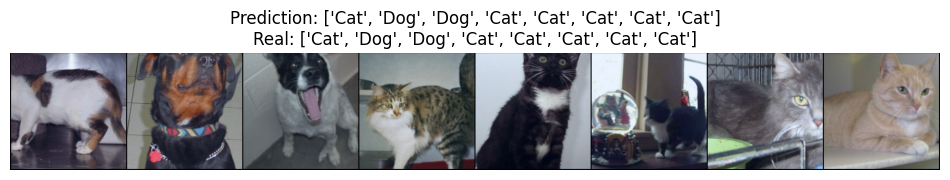

In [229]:
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        break

pred = (torch.sigmoid(pred).squeeze().detach().cpu().numpy() > 0.5).astype(int)
grid = make_grid(X[:8], normalize= True)

plt.figure(figsize = (12, 12))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title(f'Prediction: {[labels_dict[pred[i]] for i in pred[:8]]}\n'
          f'Real: {[labels_dict[y.cpu().numpy()[i]] for i in pred[:8]]}')

plt.axis(False)
plt.show()

## work tif with dataset

[Link](https://staging.source.coop/radiantearth/african-crops-kenya-02)

[Kaggle](https://www.kaggle.com/discussions/general/435213)

The objective is to create a machine learning model to classify fields by crop type from images collected during the growing season by the Sentinel-2 satellites.

The dataset is catalogued in four tiles. These tiles are smaller than the original Sentinel-2 tile that has been clipped and chipped to the geographical area where labels have been collected.

<br>

- Each tile has:
1. 13 multi-band observations throughout the growing season. Each observation includes 12 bands from Sentinel-2 L2A product and a cloud probability layer.
> The twelve bands are [B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]. The cloud probability layer is a product of the Sentinel-2 atmospheric correction algorithm (Sen2Cor) and provides an estimated cloud probability (0-100%) per pixel. All of the bands are mapped to a common 10 m spatial resolution grid
2. A raster layer indicating the crop ID for the fields in the training set
3. A raster layer indicating field IDs for the
fields (both training and test sets). Fields with a crop ID of 0 are the test fields.

In [56]:
!#!/bin/bash
!curl -L -o ./crop.zip https://www.kaggle.com/api/v1/datasets/download/warcoder/kenya-crop-type-detection

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3570M  100 3570M    0     0  76.4M      0  0:00:46  0:00:46 --:--:-- 63.9M


In [59]:
!unzip /content/crop.zip

unzip:  cannot find or open /content/data, /content/data.zip or /content/data.ZIP.


In [ ]:
!pip install rasterio

In [74]:
import rasterio

Data type: float32
Data shape: (3035, 2016)
Data range: [0.0, 1.1375000476837158]
NoData value: None


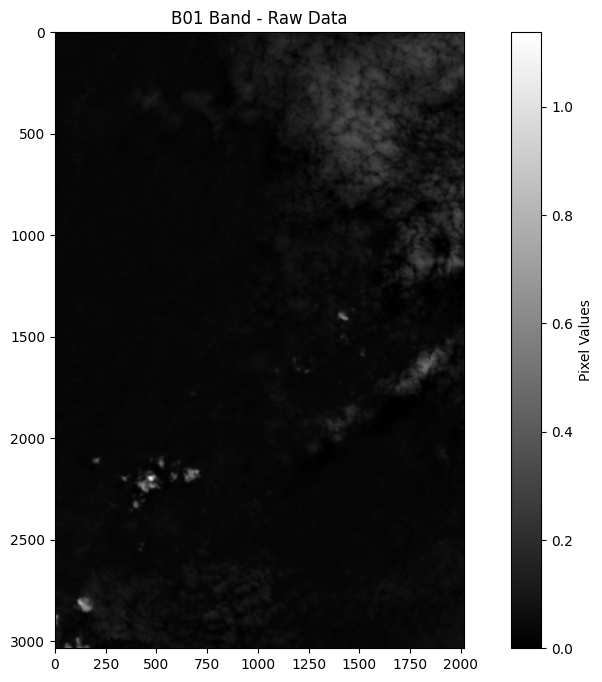

In [90]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# For the source image (B01.tif)
path = '/content/data/ref_african_crops_kenya_02_source/ref_african_crops_kenya_02_tile_00_20190606/B01.tif'

with rasterio.open(path) as src:
    # Read the data
    data = src.read(1)  # Read first band

    print(f"Data type: {data.dtype}")
    print(f"Data shape: {data.shape}")
    print(f"Data range: [{data.min()}, {data.max()}]")
    print(f"NoData value: {src.nodata}")

    # Handle NoData values
    if src.nodata is not None:
        data = np.ma.masked_where(data == src.nodata, data)

    # Display with proper stretching
    plt.figure(figsize=(12, 8))
    plt.imshow(data, cmap='gray')
    plt.colorbar(label='Pixel Values')
    plt.title('B01 Band - Raw Data')
    plt.show()

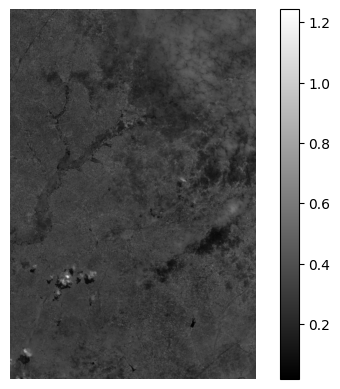

In [105]:
path = '/content/data/ref_african_crops_kenya_02_source/ref_african_crops_kenya_02_tile_00_20190606/B08.tif'

img = np.array(Image.open(path))

plt.imshow(img, cmap = 'gray')
plt.colorbar()
plt.axis(False)
plt.show()

In [110]:
fid = '/content/data/ref_african_crops_kenya_02_labels/ref_african_crops_kenya_02_tile_00_label/field_ids.tif'
label = '/content/data/ref_african_crops_kenya_02_labels/ref_african_crops_kenya_02_tile_00_label/raster_labels.tif'

print(np.unique(Image.open(label)))

[0 1 2 3 4 5 6 7]


In [70]:
path = '/content/data/ref_african_crops_kenya_02_labels'

data = {
    'tile': [],
    'row': [],
    'col': [],
    'field_id': [],
    'label': []
}

for dir in tqdm(os.listdir(path), desc = 'Tiles'):
    if 'tile' in dir:
        tile = dir.split('_')[-2]
        sub_path = os.path.join(path, dir)
        field = np.array(Image.open(os.path.join(sub_path, 'field_ids.tif')))
        label = np.array(Image.open(os.path.join(sub_path, 'raster_labels.tif')))

        rows, cols = np.where(field != 0)
        print(f"Tile {tile}: {len(rows)} fields found")

        for i in tqdm(range(len(rows)), leave = False):
            data['tile'].append(tile)
            data['row'].append(rows[i])
            data['col'].append(cols[i])
            data['field_id'].append(field[rows[i], cols[i]])
            data['label'].append(label[rows[i], cols[i]])

Tiles:   0%|          | 0/6 [00:00<?, ?it/s]

Tile 02: 1993 fields found


  0%|          | 0/1993 [00:00<?, ?it/s]

Tile 00: 4344 fields found


  0%|          | 0/4344 [00:00<?, ?it/s]

Tile 03: 51539 fields found


  0%|          | 0/51539 [00:00<?, ?it/s]

Tile 01: 9681 fields found


  0%|          | 0/9681 [00:00<?, ?it/s]

In [144]:
df = pd.DataFrame(data)
print(df.shape)
df.head()

(67557, 5)


,tile,row,col,field_id,label
0,02,224,122,2484,1
1,02,224,123,2484,1
2,02,224,128,74,0
3,02,225,121,2484,1
4,02,225,122,2484,1


In [147]:
import warnings
warnings.filterwarnings('ignore')

In [148]:
path2 = "/content/data/ref_african_crops_kenya_02_source"


for dir2 in tqdm(os.listdir(path2), desc = 'Dirctories'):
    if 'json' not in dir2:
        tile_name = dir2.split('_')[-2]
        day = dir2.split('_')[-1]
        index_filter = df['tile'] == tile_name
        rows = df[index_filter][['row']].values
        cols = df[index_filter][['col']].values

        if len(rows) == 0:
            print(f"  No matching label data for tile {tile_name}")
            continue

        new_path = os.path.join(path2, dir2)
        for file in tqdm(os.listdir(new_path), desc = 'Tiff images', leave = False):
            if 'json' not in file:
                name = file.split('.')[0]
                band_column = f'{name}_{day}'
                img = np.array(Image.open(os.path.join(new_path, file)))

                if band_column not in df.columns:
                    df[band_column] = np.nan

                df.loc[df['tile'] == tile_name, band_column] = img[rows, cols]

Dirctories:   0%|          | 0/53 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

Tiff images:   0%|          | 0/14 [00:00<?, ?it/s]

In [149]:
print(df.shape)
df.head()

(67557, 174)


,tile,row,col,field_id,label,B05_20190924,B02_20190924,B12_20190924,CLD_20190924,B03_20190924,...,CLD_20191103,B03_20191103,B06_20191103,B8A_20191103,B04_20191103,B09_20191103,B07_20191103,B08_20191103,B11_20191103,B01_20191103
0,02,224,122,2484,1,0.1846,0.0705,0.2413,0.0,0.1164,...,0.0,0.0832,0.3137,0.3847,0.0634,0.3592,0.3712,0.3746,0.2504,0.0446
1,02,224,123,2484,1,0.1846,0.0679,0.2413,0.0,0.1154,...,0.0,0.0847,0.3137,0.3847,0.0619,0.3592,0.3712,0.3794,0.2504,0.0446
2,02,224,128,74,0,0.1732,0.0536,0.2265,0.0,0.0871,...,0.0,0.1096,0.2914,0.3398,0.0956,0.3402,0.3374,0.3479,0.2761,0.0493
3,02,225,121,2484,1,0.1945,0.0705,0.2641,0.0,0.1168,...,0.0,0.0814,0.3201,0.3872,0.0562,0.3609,0.3853,0.4094,0.2415,0.0421
4,02,225,122,2484,1,0.1836,0.0775,0.2623,0.0,0.1210,...,0.0,0.0796,0.3188,0.4024,0.0597,0.3609,0.3874,0.3945,0.2194,0.0421
